In [2]:
# ====== pipsas =======

# implementación
import gymnasium as gym 
import ale_py         
import torch                    
import torch.nn as nn           
import torch.optim as optim     
import numpy as np             
import random                   
from collections import deque

# graficas
import matplotlib.pyplot as plt     

# guardar y cargar 
import os    

In [3]:
# ====== max rendimiento ======

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

🚀 Comenzando entrenamiento desde cero...
Episode 1, Total Reward: 20.0, Epsilon: 0.995
Episode 2, Total Reward: 30.0, Epsilon: 0.990
Episode 3, Total Reward: 13.0, Epsilon: 0.985
Episode 4, Total Reward: 18.0, Epsilon: 0.980
Episode 5, Total Reward: 10.0, Epsilon: 0.975
Episode 6, Total Reward: 14.0, Epsilon: 0.970
Episode 7, Total Reward: 26.0, Epsilon: 0.966
Episode 8, Total Reward: 48.0, Epsilon: 0.961
Episode 9, Total Reward: 29.0, Epsilon: 0.956


C:\Users\ST\AppData\Local\Temp\ipykernel_23404\4210123961.py:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states = torch.FloatTensor(states).to(device)


Episode 10, Total Reward: 43.0, Epsilon: 0.951
Episode 11, Total Reward: 12.0, Epsilon: 0.946
Episode 12, Total Reward: 13.0, Epsilon: 0.942
Episode 13, Total Reward: 12.0, Epsilon: 0.937
Episode 14, Total Reward: 16.0, Epsilon: 0.932
Episode 15, Total Reward: 13.0, Epsilon: 0.928
Episode 16, Total Reward: 39.0, Epsilon: 0.923
Episode 17, Total Reward: 21.0, Epsilon: 0.918
Episode 18, Total Reward: 14.0, Epsilon: 0.914
Episode 19, Total Reward: 13.0, Epsilon: 0.909
Episode 20, Total Reward: 10.0, Epsilon: 0.905
Episode 21, Total Reward: 39.0, Epsilon: 0.900
Episode 22, Total Reward: 61.0, Epsilon: 0.896
Episode 23, Total Reward: 16.0, Epsilon: 0.891
Episode 24, Total Reward: 49.0, Epsilon: 0.887
Episode 25, Total Reward: 29.0, Epsilon: 0.882
Episode 26, Total Reward: 11.0, Epsilon: 0.878
Episode 27, Total Reward: 23.0, Epsilon: 0.873
Episode 28, Total Reward: 43.0, Epsilon: 0.869
Episode 29, Total Reward: 23.0, Epsilon: 0.865
Episode 30, Total Reward: 31.0, Epsilon: 0.860
Episode 31, T

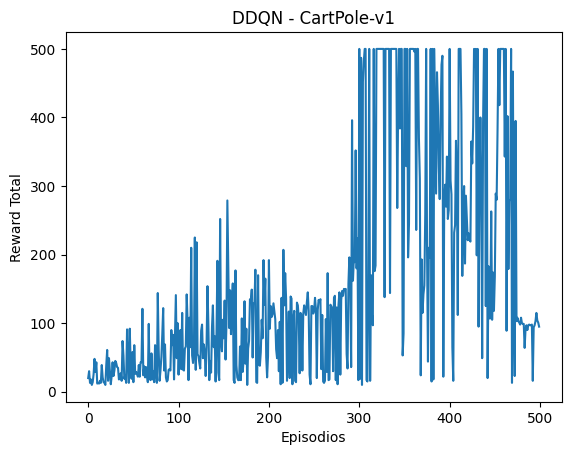

In [ ]:

# Red Q simple porque el estado de CartPole es bajo dimensional
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_size):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        return self.fc(x)

class DDQNAgent:
    def __init__(self, state_dim, action_size):
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.lr = 1e-3

        self.policy_net = QNetwork(state_dim, action_size).to(device)
        self.target_net = QNetwork(state_dim, action_size).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

        self.update_target_network()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        current_q = self.policy_net(states).gather(1, actions)
        next_actions = torch.argmax(self.policy_net(next_states), dim=1, keepdim=True)
        next_q = self.target_net(next_states).gather(1, next_actions)
        target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = self.criterion(current_q, target_q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def save(self, path):
        torch.save(self.policy_net.state_dict(), path)

    def load(self, path):
        self.policy_net.load_state_dict(torch.load(path, map_location=device))
        self.update_target_network()

# ========== ENVIRONMENT ==========
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DDQNAgent(state_dim, action_size)

checkpoint_path = "ddqn_cartpole.pth"
if os.path.exists(checkpoint_path):
    agent.load(checkpoint_path)
    print("✅ Checkpoint cargado.")
else:
    print("🚀 Comenzando entrenamiento desde cero...")

# ========== TRAINING LOOP ==========
episodes = 500
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
rewards_history = []

for ep in range(episodes):
    obs, _ = env.reset()
    state = np.array(obs, dtype=np.float32)
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state, epsilon)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = np.array(next_obs, dtype=np.float32)

        agent.remember(state, action, reward, next_state, done)
        agent.replay()
        state = next_state
        total_reward += reward

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    agent.update_target_network()
    rewards_history.append(total_reward)
    print(f"Episode {ep+1}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    # Guardar checkpoint cada 50 episodios
    if (ep + 1) % 50 == 0:
        agent.save(checkpoint_path)
        print(f"💾 Checkpoint guardado en episodio {ep + 1}")

agent.save(checkpoint_path)
print("✅ Entrenamiento finalizado y modelo guardado.")
env.close()

# ============ GRAFICAR REWARD ============
plt.plot(rewards_history)
plt.xlabel('Episodios')
plt.ylabel('Reward Total')
plt.title('DDQN - CartPole-v1')
plt.show()
